In [38]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib import ticker
import pandas as pd

### pretrain/oracle klom distribution vs. number of models N

In [ ]:
# ---------------------------- basic parameters --------------------------- #
tmp_dir     = Path("./tmp")                # where klom_*.pt live
forget_ids  = range(1, 9)                  # 1 … 8
n_values    = np.linspace(2, 100, 20, dtype=int)
figsize     = (18, 32)
# ------------------------------------------------------------------------- #

# ---------------------------- load everything ---------------------------- #
data = {fid: {"forget": {}, "retain": {}, "val": {}} for fid in forget_ids}

for n in n_values:
    res = torch.load(tmp_dir / f"klom_{n}.pt", map_location="cpu")
    for fid in forget_ids:
        for cat in ("forget", "retain", "val"):
            data[fid][cat][n] = np.asarray(res[cat][fid])

# ---------------------------- start plotting ----------------------------- #
plt.style.use("seaborn-v0_8-whitegrid")

n_rows, n_cols = len(forget_ids), 3
fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=figsize,
                         sharex=False, sharey=False,   # every subplot shows ticks
                         constrained_layout=True)

# ⬤ / ◆ marker styles for percentiles
percentiles = {
    95: dict(marker="o", ms=7, mfc="red",   mec="darkred",   label="95 %"),
    99: dict(marker="D", ms=7, mfc="green", mec="darkgreen", label="99 %")
}

for row, fid in enumerate(forget_ids):
    for col, cat in enumerate(("forget", "retain", "val")):
        ax = axes[row, col]

        # ----------- box-plot data in n-value order -------------------- #
        series = [np.asarray(data[fid][cat][n]) for n in n_values]

        ax.boxplot(series,
                   positions=n_values,
                   patch_artist=True,            # allow face colour
                   widths=1.5,
                   boxprops   =dict(facecolor="#8ecae6", edgecolor="black", linewidth=1),
                   medianprops=dict(color="#023047", linewidth=1.4),
                   whiskerprops=dict(color="black", linewidth=1),
                   capprops   =dict(color="black", linewidth=1),
                   flierprops =dict(marker=".", markersize=2, alpha=0.4),
                   manage_ticks=False)

        # ----------- overlay 95-th & 99-th percentile markers ---------- #
        for p, style in percentiles.items():
            y = [np.percentile(s, p) for s in series]
            kwargs = {k: v for k, v in style.items() if k != "label"}
            ax.plot(n_values, y, linestyle="None", **kwargs)

        # ---------------- axis cosmetics ------------------------------- #
        ax.set_xticks(n_values)
        ax.set_xticklabels(n_values, rotation=45, ha="right", fontsize=9)
        ax.set_yticks(ax.get_yticks())
        ax.tick_params(axis="y", labelsize=9)
        ax.set_xlabel("number of pre-trained models $N$", fontsize=11)
        ax.set_ylabel(r"$\operatorname{KLOM}$", fontsize=11)
        ax.set_title(cat.upper(), fontsize=12, pad=6)
        ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))

    # -------- row title spanning the three panels --------------------- #
    axes[row, 1].annotate(f"Forget Set {fid}",
                          xy=(0.5, 1.12), xycoords="axes fraction",
                          ha="center", va="bottom",
                          fontsize=13, fontweight="bold")

# ------------------------- single shared legend -------------------------- #
handles, labels = [], []
for p, style in percentiles.items():
    h, = axes[0, 0].plot([], [], **{k: v for k, v in style.items() if k != "label"})
    handles.append(h); labels.append(style["label"])
fig.legend(handles, labels,
           loc="upper right",
           bbox_to_anchor=(0.99, 1.01),
           frameon=True,
           fontsize=13,
           edgecolor='black',
           fancybox=False)

fig.suptitle("KLOM distribution vs. number of models $N$",
             fontsize=16, y=1.02, fontweight="bold")

plt.savefig("klom_distribution.png")
plt.show()

### klom plots

In [72]:
from paths import EVAL_DIR, FORGET_INDICES_DIR
from ast import literal_eval
from datasets import DATASETS
dataset_name = "cifar10"
model_name = "resnet9"
KLOM_PATH = EVAL_DIR / dataset_name / model_name
FDIR = FORGET_INDICES_DIR / dataset_name
forget_sets = [1,2,4,6,7,8,9]
TOTAL_EPOCHS = 24
forget_indices = {i: torch.load(FDIR / f"forget_indices_{i}.pt") for i in forget_sets}
train_size = DATASETS[dataset_name]["train_size"]
val_size = DATASETS[dataset_name]["val_size"]
retain_indices = {i: [k for k in range(train_size) if k not in forget_indices[i]] for i in forget_sets}
val_indices = [k for k in range(train_size, train_size+val_size)]

def get_klom_stats(klom, key):
    return {f"{key}_klom_95": np.percentile(klom, 95), f"{key}_klom_99": np.percentile(klom, 99), f"{key}_klom_mean": np.mean(klom), f"{key}_klom_std": np.std(klom)}

def parse_klom_fname(fname):
    method, lr, ep, fset, bs, lat = fname.split("__")
    lr = float(lr.split("_")[1])
    ep = literal_eval(ep.split("_")[1])
    fset = int(fset[1])
    bs = int(bs.split("bs")[1])
    n = int(lat.split("_")[1].split(".")[0])
    res = torch.load(KLOM_PATH / fname)
    rows = []
    for e_id, klom in res.items():
        total_cost = (len(forget_indices[fset]) + len(retain_indices[fset]) + len(val_indices)) * TOTAL_EPOCHS
        if method == "ascent_forget":
            relative_cost = len(forget_indices[fset]) * e_id / total_cost
        else:
            raise NotImplementedError(f"Cost for {method} not implemented")
        assert e_id in ep, f"e_id {e_id} not in ep {ep}"
        rows.append(
            {
                "method": method,
                "lr": lr,
                "epoch": e_id,
                "forget_id": fset,
                "batch_size": bs,
                "N": n,
                "relative_cost": relative_cost,
                **get_klom_stats(klom[retain_indices[fset]], "retain"),
                **get_klom_stats(klom[val_indices], "val"),
                **get_klom_stats(klom[forget_indices[fset]], "forget"),
            }
        )
    return rows

contents = []
for fname in KLOM_PATH.iterdir():
    contents.extend(parse_klom_fname(fname.name))

In [75]:
df = pd.DataFrame(contents)
df["average_95"] = df.apply(lambda x: (x["retain_klom_95"] + x["val_klom_95"] + x["forget_klom_95"]) / 3, axis=1)
df.head()

,method,lr,epoch,forget_id,batch_size,N,relative_cost,retain_klom_95,retain_klom_99,retain_klom_mean,retain_klom_std,val_klom_95,val_klom_99,val_klom_mean,val_klom_std,forget_klom_95,forget_klom_99,forget_klom_mean,forget_klom_std,average_95
0,ascent_forget,0.001,1,4,64,100,0.000007,0.902275,1.281970,0.424629,0.248167,0.765067,1.034710,0.384248,0.198865,9.964224,9.987409,9.470969,0.408909,3.877189
1,ascent_forget,0.001,3,4,64,100,0.000021,2.646130,4.020854,0.984754,0.844634,1.754479,2.546410,0.702260,0.523471,9.944193,9.965673,6.650068,3.147243,4.781601
2,ascent_forget,0.001,5,4,64,100,0.000035,4.669047,6.627084,1.621913,1.491528,3.294316,4.645874,1.145958,1.017800,9.594704,9.810411,3.764357,3.777206,5.852689
3,ascent_forget,0.001,7,4,64,100,0.000049,6.304086,8.180246,2.168653,2.004581,4.862979,6.361594,1.597668,1.509499,8.655514,9.540595,3.102713,3.068022,6.607526
4,ascent_forget,0.001,10,4,64,100,0.000069,7.973218,9.470944,2.775696,2.543982,6.647219,8.166697,2.160709,2.080952,8.202725,8.704604,3.657104,2.521333,7.607721


In [76]:
df.groupby("forget_id")["average_95"].min()

forget_id
1    3.085289
2    3.563268
4    3.823654
6    5.007089
7    2.354647
8    4.549073
9    5.338765
Name: average_95, dtype: float64

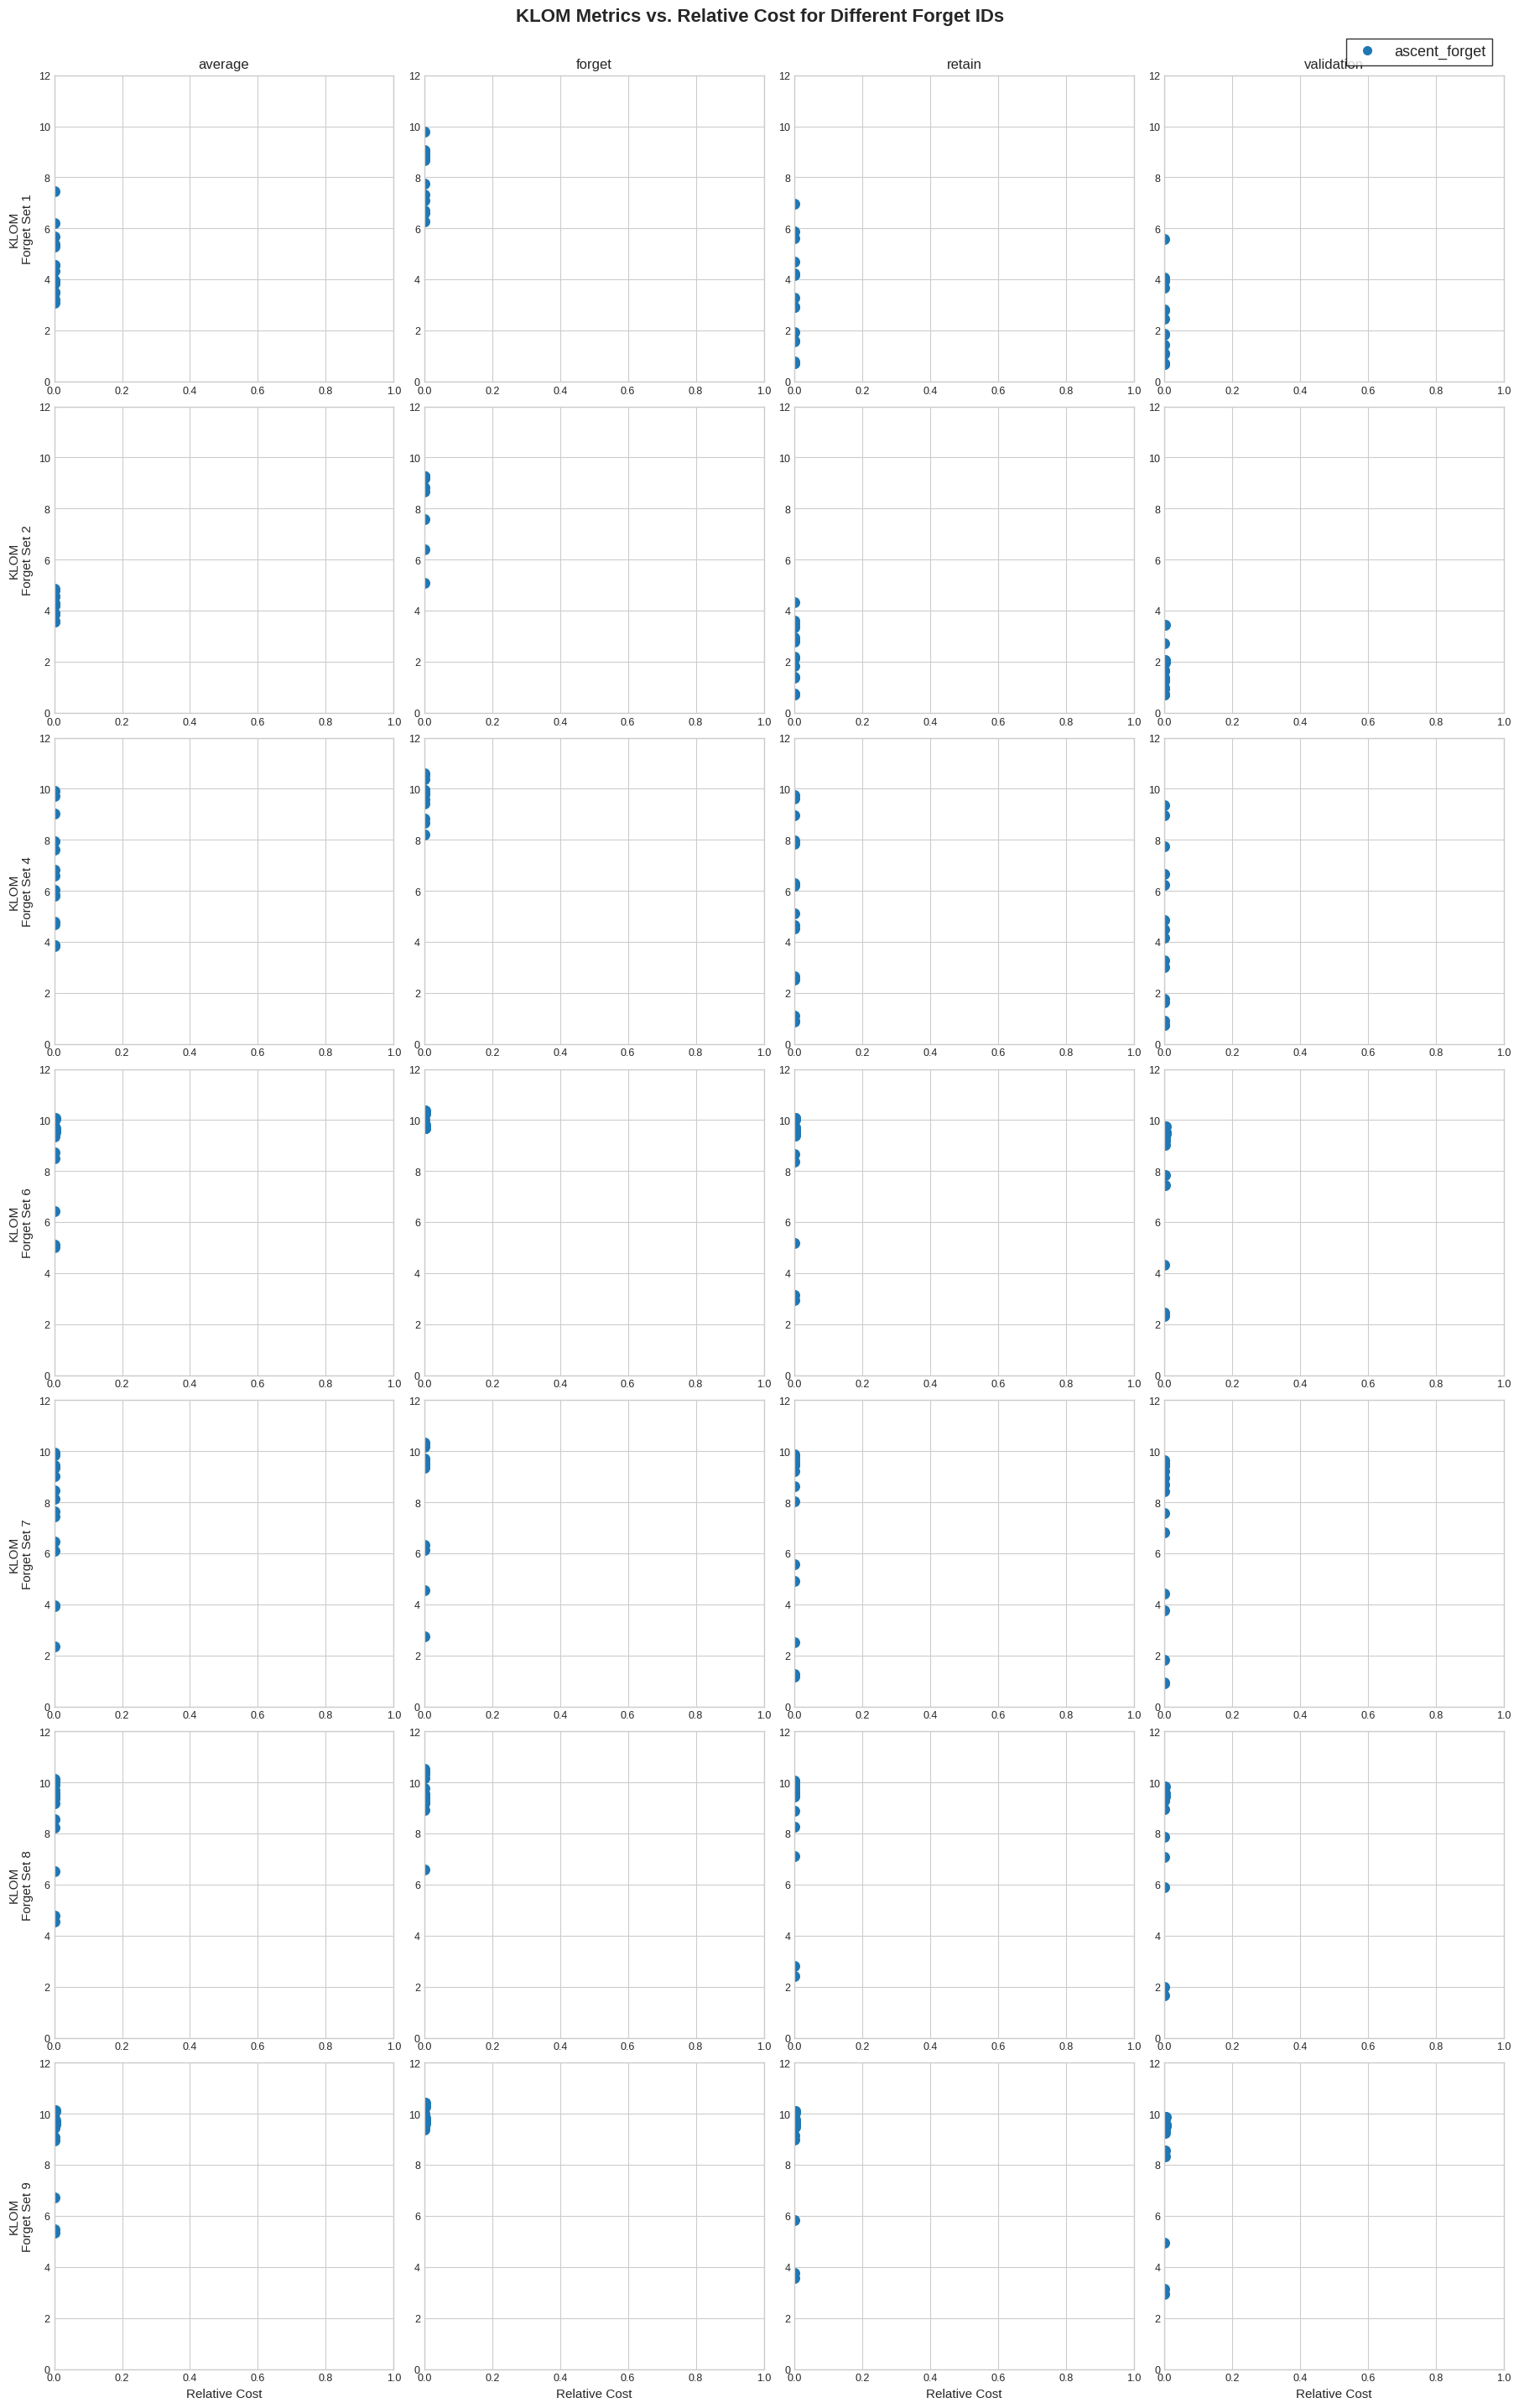

In [87]:
import matplotlib.pyplot as plt
import pandas as pd

# Make sure forget_ids are sorted
forget_ids = sorted(df['forget_id'].unique())
metrics = ['average_95', 'forget_klom_95', 'retain_klom_95', 'val_klom_95']
titles = ['average', 'forget', 'retain', 'validation']
figsize = (18, 4 * len(forget_ids))
methods = df['method'].unique()

markers = ['o', 's', 'D', '^', 'v', '<', '>', 'P', '*']  # extend if needed
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
marker_map = {method: markers[i % len(markers)] for i, method in enumerate(methods)}
color_map = {method: colors[i % len(colors)] for i, method in enumerate(methods)}

plt.style.use("seaborn-v0_8-whitegrid")

fig, axes = plt.subplots(len(forget_ids), len(metrics), figsize=figsize,
                         sharex=False, sharey=False, constrained_layout=True)

if len(forget_ids) == 1:
    axes = [axes]  # keep indexing consistent for single row

for row_idx, fid in enumerate(forget_ids):
    df_fid = df[df['forget_id'] == fid]
    for col_idx, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[row_idx][col_idx] if len(forget_ids) > 1 else axes[col_idx]
        for method in methods:
            df_method = df_fid[df_fid['method'] == method]
            ax.scatter(df_method['relative_cost'], df_method[metric],
                       marker=marker_map[method],
                       color=color_map[method],
                       s=70, label=method)

        # Only add xlabel to bottom row
        if row_idx == len(forget_ids) - 1:
            ax.set_xlabel('Relative Cost', fontsize=11)
        
        # Only add ylabel to first column
        if col_idx == 0:
            ax.set_ylabel(f'KLOM\nForget Set {fid}', fontsize=11)
        
        # Only add title to top row
        if row_idx == 0:
            ax.set_title(title, fontsize=12, pad=6)
            
        ax.tick_params(axis='both', which='both', labelsize=9)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 12)

handles = []
for method in methods:
    h = plt.Line2D([], [], linestyle='None', marker=marker_map[method],
                   color=color_map[method], markersize=7, label=method)
    handles.append(h)

fig.legend(handles, methods,
           loc="upper right",
           bbox_to_anchor=(0.99, 1.01),
           frameon=True,
           fontsize=13,
           edgecolor='black',
           fancybox=False)

fig.suptitle("KLOM Metrics vs. Relative Cost for Different Forget IDs",
             fontsize=16, y=1.02, fontweight="bold")

plt.show()